# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
!pip install progressbar2

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
# import necessary packages for this project
import copy
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import progressbar as pb
import matplotlib.pyplot as plt

In [8]:
# Hyperparameter tuning
RANDOM_SEED = 0
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 1024      
GAMMA = 0.9            
TAU = 1e-2              
LR_ACTOR = 1e-3         
LR_CRITIC = 1e-3        
WEIGHT_DECAY = 0        
NUM_AGENTS = 2
STATE_SIZE = 24
ACTION_SIZE = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
"""
Actor model: aproximates for the optimal deterministici policy
"""

class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))
"""
    Critic model: evaluates the optimal action-value function 
    by using actions from the actor
"""

class Critic(nn.Module):
    def __init__(self, state_size, action_size, fcs1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
"""
    Ornstein-Uhlenbeck process class: initialize parameters and noise
    process, resets the internal state, updates it and returnit as 
    noise sample
""""
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(RANDOM_SEED)
        self.reset()
    def reset(self):
        self.state = copy.copy(self.mu)
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.normal(loc=0, scale=1) for _ in range(len(x))])
        self.state = x + dx
        return self.state

In [11]:
"""
    ReplayBuffer class, adds and stores experience in form of tuples
"""

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(RANDOM_SEED)
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

In [12]:
def train(ddpg, env, n_episodes=1000, max_t=1000, save_every=50):
    widget = [
        "Episode: ", pb.Counter(), '/' , str(n_episodes), ' ', 
        pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ', 
        'Rolling Average: ', pb.FormatLabel('')
    ]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    solved = False
    scores_total = []
    scores_deque = deque(maxlen=100)
    rolling_score_averages = []
    best_score = 0.0
    for i_episode in range(1, n_episodes+1):
        current_average = 0.0 if i_episode == 1 else rolling_score_averages[-1]
        widget[12] = pb.FormatLabel(str(current_average)[:6])
        timer.update(i_episode)  
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations[:, -STATE_SIZE:]
        scores = np.zeros(num_agents)
        ddpg.reset()
        while True:
            actions = ddpg.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations[:, -STATE_SIZE:]
            rewards = env_info.rewards
            dones = env_info.local_done
            ddpg.step(states, actions, rewards, next_states, dones)
            scores += rewards
            states = next_states
            if np.any(dones):
                break
        max_episode_score = np.max(scores)
        scores_deque.append(max_episode_score)
        scores_total.append(max_episode_score)
        average_score = np.mean(scores_deque)
        rolling_score_averages.append(average_score)
        if average_score > best_score:
            best_score = average_score
            if solved:
                ddpg.save_model()
        if average_score >= 0.5 and not solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode, average_score
            ))
            solved = True
            ddpg.save_model()
        
        if i_episode % save_every == 0 and not solved:
            ddpg.save_model()

    ddpg.save_model()
    return scores_total, rolling_score_averages

In [13]:
"""
    Deep Deterministic Policy Gradient Network: actor-critic
    method that performs well in environments with a 
    continuous action space
"""
class DDPGAgent():
    def __init__(self, state_size, action_size, num_agents):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(RANDOM_SEED)
        self.num_agents = num_agents
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        self.critic_local = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.noise = OUNoise(action_size)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        self.model_dir = os.getcwd() + "/DDPG/saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

"""
    Save experience in replay memory, and use random sample from buffer to learn.
"""

    def step(self, states, actions, rewards, next_states, dones):
        for i in range(self.num_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
    def act(self, states, add_noise=True):
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for i, state in enumerate(states):
                # Populate list of actions one state at a time
                actions[i, :] = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)  # adds gradient clipping to stabilize learning
        self.critic_optimizer.step()
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
            
    def save_model(self):
        torch.save(
            self.actor_local.state_dict(), 
            os.path.join(self.model_dir, 'actor_params.pth')
        )
        torch.save(
            self.actor_optimizer.state_dict(), 
            os.path.join(self.model_dir, 'actor_optim_params.pth')
        )
        torch.save(
            self.critic_local.state_dict(), 
            os.path.join(self.model_dir, 'critic_params.pth')
        )
        torch.save(
            self.critic_optimizer.state_dict(), 
            os.path.join(self.model_dir, 'critic_optim_params.pth')
        )

    def load_model(self):
        """Loads weights from saved model."""
        self.actor_local.load_state_dict(
            torch.load(os.path.join(self.model_dir, 'actor_params.pth'))
        )
        self.actor_optimizer.load_state_dict(
            torch.load(os.path.join(self.model_dir, 'actor_optim_params.pth'))
        )
        self.critic_local.load_state_dict(
            torch.load(os.path.join(self.model_dir, 'critic_params.pth'))
        )
        self.critic_optimizer.load_state_dict(
            torch.load(os.path.join(self.model_dir, 'critic_optim_params.pth'))
        )

In [14]:
ddpg = DDPGAgent(STATE_SIZE, ACTION_SIZE, NUM_AGENTS)

In [15]:
# create functions to visualize the performance
def plot_results(scores, rolling_score_averages):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(1, len(scores) + 1), scores, label="Max Score")
    plt.plot(np.arange(1, len(rolling_score_averages) + 1), rolling_score_averages, label="Rolling Average")
    plt.axhline(y=0.5, color="r", linestyle="-", label="Environment Solved")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.show()



def test(agent, env, num_games=11, load_model=False):
    if load_model:
        agent.load_model()
    
    print("Agent #0: Red racket")
    print("Agent #1: Blue racket")
    print("---------------------")
    
    game_scores = [0 for _ in range(NUM_AGENTS)]

    for i in range(1, num_games+1):
        env_info = env.reset(train_mode=False)[brain_name]   
        states = env_info.vector_observations
        scores = np.zeros(NUM_AGENTS)

        while True:
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            scores += rewards
            dones = env_info.local_done

            if np.any(dones):
                winner = np.argmax(scores)
                game_scores[winner] += 1
                print("Partial game score: {}".format(game_scores))
                break

            states = next_states

    print("---------------------")
    print("Winner: Agent #{}".format(np.argmax(game_scores)))




In [16]:
# training
scores_total, rolling_score_averages = train(ddpg, env, n_episodes=2000)

Episode: 2000/2000 100% ETA:  00:00:00 |/             | Rolling Average: 0.2476

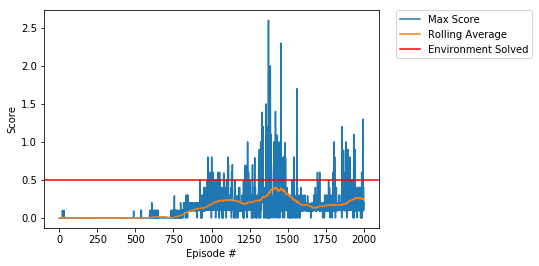

Agent #0: Red racket
Agent #1: Blue racket
---------------------
Partial game score: [0, 1]
Partial game score: [1, 1]
Partial game score: [1, 2]
Partial game score: [1, 3]
Partial game score: [1, 4]
---------------------
Winner: Agent #1


In [17]:
# plot the results of training
plot_results(scores_total, rolling_score_averages)
test(ddpg, env, num_games=5, load_model=True)